# Predicting Video Game Sales with Support Vector Machines

Another Method we evaluate to predict Global Video Game Sales is support Vector Regression. First, a contrast to Linear Regression, in which the objective is to derive the eponymous linear equation that minimizes the Squares of the errors, taking into account a regularization term to constrain the complexity of the equation.

In contrast, in a Support Vector regression, we define a hyperplane (i.e. an object with one less dimension than the data we are aiming to predict), as well as an error margin. The ideal predictor hyperplane given the width of the error margin, $\epsilon$, includes the maximum number of datapoints within the boundary:

![boundary illustration](./img/boundary.png)

All points that remain _outside_ the boundary $\epsilon$ are taken into account by their absolute deviation, $ |\xi| $ (xi). Therefore, the objective becomes minimizing the deviations outside the hyperplane (which must contain the maximum number of values), which is written as:

![minimize xi](./img/minimize_xi.png)

Ultimately, what we end up trying to achive is a hyperplane with
* minimal complexity
* that contains as many values within its margin denoted by $\epsilon$
* and minimizes the absolute deviations of values outside the boundary $|\xi|$

![complete svr](./img/epsilon_xi.png)

We will apply a standard supervised machine learning approach to an extended version of the Videogamesales data set. The explicit goal of the exercise is here to be able to predict the global sales volume from the inherent characteristics of a game upon/before release

## Data Preparation

First we will import the necessary packages and modules, namely:
* pandas/numpy for efficiently reading and preparing the data
* matplotlib/seaborn for initial graphical EDA
* scikit-learn (more detail in the single sections)

> Note: general EDA is contained in a separate notebook and some insights thereof will be taken for granted here

### Importing the Packages, reading the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
with open('./vgsales_extended.csv', mode='r') as file:
    df = pd.read_csv(file)

df.head()
df.drop(columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Name'], inplace=True)


> Note: we droup all the regional sales columns, since there is a) obvious colinearity with the "global sales" variable and more importantly, b) those data would not be available upon release of a new game

Here we take a quick look at the data again, there are a few additional columns used here, that were sourced from [videogames with ratings](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) (kaggle).

We used additional data Attributes in order to be able to better show the preprocessing needed in Support Vector Machines Specifically.

In [3]:
df.head()

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8,322.0,Nintendo,E
1,NES,1985.0,Platform,Nintendo,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8,192.0,Nintendo,E
4,GB,1996.0,Role-Playing,Nintendo,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16450.0,2006.487356,5.878995,1980.00,2003.00,2007.00,2010.00,2020.00
Global_Sales,16719.0,0.533543,1.547935,0.01,0.06,0.17,0.47,82.53
Critic_Score,8137.0,68.967679,13.938165,13.00,60.00,71.00,79.00,98.00
Critic_Count,8137.0,26.360821,18.980495,3.00,12.00,21.00,36.00,113.00
User_Count,7590.0,162.229908,561.282326,4.00,10.00,24.00,81.00,10665.00


In [5]:
df.dtypes

Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

## Preprocessing

Potential issues that become obvious here are:
1. not all data is numeric 
2. some Attributes of the data also exhibit missing data

### First, non-numeric data (since dealing with it eliminates missing data, in part). 

We know that Support Vector regression can only process numeric data, as should be intuitively clear from the mathematical background described in the beginning - we calculate distances, both in order to estimate whether or not a value should be taken into consideration because it falls within the boundary defined via $\epsilon$ as well as the deviations $\sum{|\xi|}$ of values _outside_ the boundary. 

So in order to utilize non-numeric attributes in any meaningful way, we need to _One-hot-encode_ the data. [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

Since for each unique value, One-hot-encoding produces a new attribute/column, let's first look at how many unique values there actually are in the relevant columns.

In [6]:
for i in ['Platform', 'Genre', 'Publisher', 'Developer']:
    print(f'Column {i} - unique values: {df[i].unique().shape[0]}')

Column Platform - unique values: 31
Column Genre - unique values: 13
Column Publisher - unique values: 582
Column Developer - unique values: 1697


31 Platforms seems reasonable, but close to 600 different Publishers are clearly not a meaninful feature. Intuitively, would expect something approximating a Pareto distribution here; so, let's further look at how many Games are produced per Publisher: 

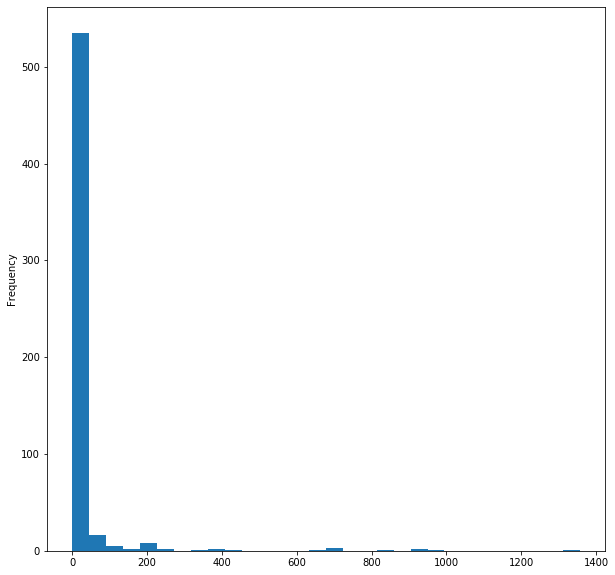

In [7]:
df.groupby('Publisher').size().plot(kind='hist', bins=30, figsize=(10,10))
#df['Publisher'].plot(kind='hist')

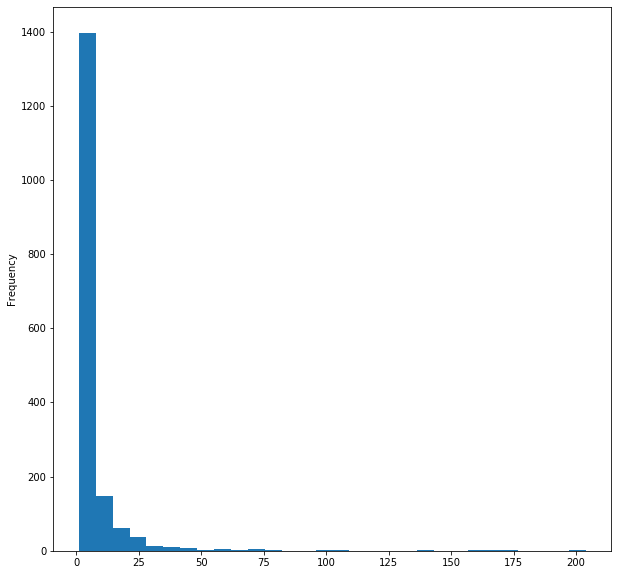

In [8]:
df.groupby('Developer').size().plot(kind='hist', bins=30, figsize=(10,10))
#df['Publisher'].plot(kind='hist')

This is more or less what we expected. We want to avoid overfitting and also eliminate useless features. We will bin all the publishers/developers/platforms that are not in the top 10/20 into an 'other' category. Thereby, while we do lose a bit of information, we avoid a matrix with 1500+ columns and still keep all of our data (in this step.

> Our objective is, for the sake of this exercise, to be able to "bet" on future hit games with reasonable certainty, this makes sense since a) small studios without a track record are inherently difficult to predict and b) games released on large platforms are inherently are more target-rich group - thereby, the specific name of an indie studio would arguably hold no more information than the information that it was not produced by a large company

Publishers (in descending order of games published) taken into account:

In [9]:
top_publishers = df.groupby('Publisher').size().sort_values(ascending=False).head(10).index.to_list()
for i in top_publishers:
    print(f'-) {i}')

-) Electronic Arts
-) Activision
-) Namco Bandai Games
-) Ubisoft
-) Konami Digital Entertainment
-) THQ
-) Nintendo
-) Sony Computer Entertainment
-) Sega
-) Take-Two Interactive


Platforms, also in descending order of games published

In [10]:
top_platforms = df.groupby('Platform').size().sort_values(ascending=False).head(10).index.to_list()
for i in top_platforms:
    print(f'-) {i}')

-) PS2
-) DS
-) PS3
-) Wii
-) X360
-) PSP
-) PS
-) PC
-) XB
-) GBA


Developers, in descending order

In [11]:
top_developers = df.groupby('Developer').size().sort_values(ascending=False).head(20).index.to_list()
for i in top_developers:
    print(f'-) {i}')

-) Ubisoft
-) EA Sports
-) EA Canada
-) Konami
-) Capcom
-) EA Tiburon
-) Electronic Arts
-) Ubisoft Montreal
-) Visual Concepts
-) Omega Force
-) Traveller's Tales
-) Vicarious Visions
-) Activision
-) TT Games
-) Nintendo
-) THQ
-) Namco
-) Codemasters
-) Artificial Mind and Movement
-) Midway


In [12]:
df['Platform'] = df['Platform'].where(df['Platform'].isin(top_platforms), 'other')
df.groupby('Platform').size().sort_values(ascending=False)

Platform
other    3467
PS2      2161
DS       2152
PS3      1331
Wii      1320
X360     1262
PSP      1209
PS       1197
PC        974
XB        824
GBA       822
dtype: int64

In [13]:
df['Publisher'] = df['Publisher'].where(df['Publisher'].isin(top_publishers), 'other')
df.groupby('Publisher').size().sort_values(ascending=False)

Publisher
other                           8504
Electronic Arts                 1356
Activision                       985
Namco Bandai Games               939
Ubisoft                          933
Konami Digital Entertainment     834
THQ                              715
Nintendo                         706
Sony Computer Entertainment      687
Sega                             638
Take-Two Interactive             422
dtype: int64

In [14]:
df['Developer'] = df['Developer'].where(df['Developer'].isin(top_developers), 'other')
df.groupby('Developer').size().sort_values(ascending=False)

Developer
other                           14692
Ubisoft                           204
EA Sports                         172
EA Canada                         167
Konami                            162
Capcom                            139
EA Tiburon                        108
Electronic Arts                   104
Ubisoft Montreal                  101
Visual Concepts                    99
Omega Force                        80
Traveller's Tales                  77
Vicarious Visions                  76
Activision                         75
TT Games                           73
Nintendo                           72
THQ                                71
Namco                              64
Codemasters                        62
Artificial Mind and Movement       61
Midway                             60
dtype: int64

So now it should be clear why we dealt with our categories first - presumably, by filling a significant amount of our data with 'other', we have dealt with a number of the missing records already.
The remaining data can now be one-hot-encoded without large concern, _after_ we have dealt with missing values.

### Second, Missing Data

First of all, we want to know how much data is missing altogether here. We do this at first in terms of how much data is missing as a percentage of the total, since we want to impute out missing data with the median, if at all possible.

In [15]:
df.isna().mean().sort_values(ascending=False)

User_Count         0.546025
Critic_Count       0.513308
Critic_Score       0.513308
Rating             0.404869
User_Score         0.400981
Year_of_Release    0.016089
Genre              0.000120
Developer          0.000000
Global_Sales       0.000000
Publisher          0.000000
Platform           0.000000
dtype: float64

What has become apparent here is that:
1. Some variables have a significant portion of their data missing
2. some attributes do not make much sense for imputation

As for 2, it does not seem to make much sense to impute the release year of a game with the median. Even though this is an ordinal attribute, there is no reason to assume that imputing the central value makes sense here. Furthermore, year of release is a very small fraction (<2%) of the missing data which we can comfortably drop.

Much more critically, while some fraction of the data may be imputed, upwards of 40% missing data is not reasonable to impute with either median imputation or hot-deck imputation.

We first drop these records, and then see how large a fraction remains missing in the other attibutes.

> Note: obviously, this opens our model up to hidden factors here. It seems absolutely plausible that some confounding factor influences the fact that data on these specific games is missing. Maybe Critic coverage on indie studios is simply not extensive enough to provide user counts, critics reviews or ratings. This **definiteily** opens us up to black swan events (e.g. "dark horse" titles that are hugely successful "out of nowhere" because traditional models were trained on the mainstream and were poised to overlook them)! This topic is rather out of scope here, but we did take note of it (and maybe model-based imputation or modelling on missing values explicitly mitigates this issue in a further investigation)

In [16]:
df.dropna(subset=['Year_of_Release', 'Publisher', 'User_Count', 'Developer', 'Rating'], inplace=True)
y = np.array(df['Global_Sales'])
df.drop(columns=['Global_Sales'], inplace=True)

In [17]:
df.isna().mean().sort_values(ascending=False)

Critic_Count       0.075068
Critic_Score       0.075068
Rating             0.000000
Developer          0.000000
User_Count         0.000000
User_Score         0.000000
Publisher          0.000000
Genre              0.000000
Year_of_Release    0.000000
Platform           0.000000
dtype: float64

So we see here that the remaining data missing <10% which may comfortably be imputed using the median.

### Finally, scaling data

Since SVR Kernel Methods are all based on distance (as mentioned above) features need to be on the same scale here. Since we looked at the distribution of our data here and in the initial EDA we know that our data (and our outcome variable) are initially quite far away from being normally distributed.

Again, this is not surprising since these behaviorally-based success outcomes (Music Consumption, Book Sales, Film Success etc. etc.) are fundamentally Pareto-distributed.

So we first check if this is still the case and how large the outliers appear to be:

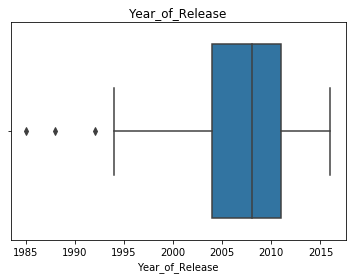

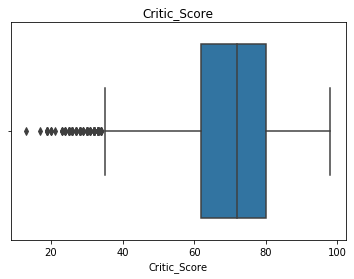

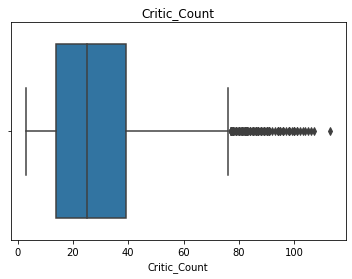

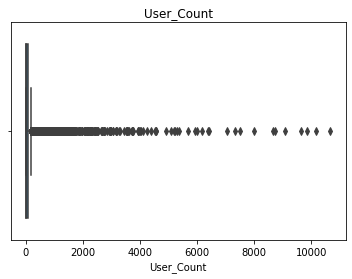

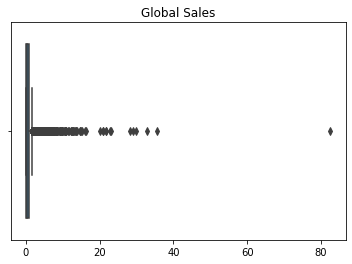

In [18]:
numeric_features = [j for j in df.columns if df[j].dtype in [np.int64, np.float64]]
categorical_features = list(filter(lambda x: x not in numeric_features, df.columns))

for i in numeric_features:
    sns.boxplot(df[i]).set_title(i)
    plt.show()

sns.boxplot(y).set_title('Global Sales')
plt.show()

It is obvious that some variables (User Count, Global Sales, the most behaviorally-driven features) show strong outliers. We will therefore use a RobustScaler, that is we will scale along the interquartile range in order to mitigate the effect of these extreme outliers.

> Again, in a deeper analysis we might want to take a close look at these outliers, in a clustering approach for example, since they might share commonalities (as extremely successfull titles) that we want to specifically train our model to recognize. This would be one hint that Tree Based ensemble models (specifically, Adaptive Boosting) may be very well suited since they incorporate parts of this approach (i.e. zooming in on the residuals). 

In Order to process all our data in one step, we create pipelines that we fit into a column transformer. This allows us to reverse transform our results after prediction (as seen below).

Finally, we split out data into train / test sets.

In [19]:
pipe_numeric = Pipeline(steps=[('imputation', SimpleImputer(strategy='median')),
                               ('scaling', MinMaxScaler())])
pipe_categorical = Pipeline(steps=[('encoding', OneHotEncoder())])

preprocessor_X = ColumnTransformer(transformers=[
    ('numerical', pipe_numeric, numeric_features),
    ('categorical', pipe_categorical, categorical_features)])

X = preprocessor_X.fit_transform(df)
transformer_y = RobustScaler()
transformer_y.fit(y.reshape(-1,1))
y = transformer_y.transform(y.reshape(-1,1))

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42)

After Processing our data, we train an initial SVR model, with polynomial kernel of grade 3 as a first estimate and look at the R2 (coefficient of determination) and mean squared error in our test set.

In [20]:
svm_regressor = SVR(kernel='poly', degree=3, C=10)
svm_regressor.fit(train_X, train_y)
svm_regressor.score(test_X, test_y)

/usr/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.283135037821588

In [21]:
mse = mean_squared_error(test_y.ravel(), svm_regressor.predict(test_X))
processed_mse = transformer_y.inverse_transform([[mse]])
rmse = processed_mse**.5
rmse[0][0]

2.674979796947559

We see from our R2 score that our model only accounts for ~30% of the variation seen in our data, as measured on the validation set. Since our data overall has a very large degree of variance (and heteroskedacity, on top of not being normally distributed) to begin with, this still seems underwhelming. 

Furthermore, we can see via our inverse-processed RMSE that our typical prediction is almost 3 Million units in sales off the mark.

We will see if we can improve our model further via a grid search:

In [22]:
param_grid = [{'C': [0.1, 1, 3], 
               'gamma': [0.1, 1, 3],
               'kernel': ['poly'],
               'degree': [2,3]}]

gridsearch = GridSearchCV(SVR(), param_grid, n_jobs=-1)
gridsearch.fit(train_X, train_y)
gridsearch.best_score_

/usr/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3733846838870957

In [23]:
gridsearch.best_params_

{'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}

In [24]:
svr = gridsearch.best_estimator_
svr.score(test_X, test_y)

0.3822235645506696

As we can see from our (non-exhaustive) grid search here, our model can still be significantly improved - we increased R2 to an arguably still underwhelming .38 so far. Furthermore, during a few rounds of running grid search we had to explicitly exclude lower regularization parameters C, since the model tended to overfit with C < 1 (the test R2 decreasing by up to a third with a C of .05 for example, which is a clear indicator that our hyperplane was fitting the data too closely). 

While grid search across such parameters as here is a fairly common way to tune SVR models, it is computationally expensive and thereby time-consuming. A better way forward may be evolutionary search algorithms, as proposed in papers such as [this one](https://www.researchgate.net/publication/222550564_Evolutionary_tuning_of_multiple_SVM_parameters).

Finally, we may improve our performance by engineering new features from the existing features, or transforming the scale of our outcome variables to compensate for the high heteroskedacity. While Support Vector Regression can be a powerful method, we suspect it is not the ideal approach to this scenario.